This notebook is based on DataCamp course on ["Big Data Fundamentals via PySpark"](https://www.datacamp.com/courses/big-data-fundamentals-via-pyspark)

import findspark

findspark.init()

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc,col

from time import time
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession\
    .builder\
    .appName("big-data")\
    .getOrCreate()

# spark = SparkSession.builder.getOrCreate()      # appName is optional

In [3]:
spark

In [6]:
spark.version

'2.4.3'

In [4]:
sc = spark.sparkContext

In [5]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [8]:
sc.version, sc.master, sc.appName, sc.pythonVer

('2.4.3', 'local[*]', 'big-data', '3.7')

In [7]:
# Print the tables in the catalog
print(spark.catalog.listTables())

[]


<img src=01.png/>

<img src=02.png/>

#### 3 ways to create RDD

1) parallelizing an existing collection of objects

In [8]:
rdd1 = sc.parallelize(range(10))

In [9]:
type(rdd1)

pyspark.rdd.PipelinedRDD

In [10]:
rdd1.collect()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [13]:
df = spark.range(10)

In [14]:
type(df)

pyspark.sql.dataframe.DataFrame

In [15]:
df.show(5)

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+
only showing top 5 rows



In [16]:
df.collect()

[Row(id=0),
 Row(id=1),
 Row(id=2),
 Row(id=3),
 Row(id=4),
 Row(id=5),
 Row(id=6),
 Row(id=7),
 Row(id=8),
 Row(id=9)]

In [23]:
!pwd

/home/gong/projects/py4kids/lesson-17-pyspark/datacamp/03_big-data-via-pyspark


In [10]:
!ls

01.png	04.png			    clustering.png    README.md
02.png	big-data-via-pyspark.ipynb  data	      slides
03.png	classification.png	    plt_pandas.ipynb


2) external datasets:

* HDFS files
* S3 bucket objects
* lines in a text file

In [17]:
rdd2 = sc.textFile("README.md")

In [25]:
rdd2.take(15)

['# Apache Spark',
 '',
 'Spark is a fast and general cluster computing system for Big Data. It provides',
 'high-level APIs in Scala, Java, Python, and R, and an optimized engine that',
 'supports general computation graphs for data analysis. It also supports a',
 'rich set of higher-level tools including Spark SQL for SQL and DataFrames,',
 'MLlib for machine learning, GraphX for graph processing,',
 'and Spark Streaming for stream processing.',
 '',
 '<http://spark.apache.org/>',
 '',
 '',
 '## Online Documentation',
 '',
 'You can find the latest Spark documentation, including a programming']

In [24]:
rdd2.count()

105

3) transforming RDD to new RDD

In [21]:
# line contains "Spark"
rdd3 = rdd2.filter(lambda x: 'spark' in x.lower())

In [22]:
rdd3.take(5)

['# Apache Spark',
 'Spark is a fast and general cluster computing system for Big Data. It provides',
 'rich set of higher-level tools including Spark SQL for SQL and DataFrames,',
 'and Spark Streaming for stream processing.',
 '<http://spark.apache.org/>']

In [28]:
print(rdd3)

PythonRDD[24] at RDD at PythonRDD.scala:53


In [26]:
# line starts with "Spark"
rdd3_1 = rdd3.filter(lambda x: 'Spark' == x.split()[0])

In [27]:
rdd3_1.take(5)

['Spark is a fast and general cluster computing system for Big Data. It provides',
 'Spark is built using [Apache Maven](http://maven.apache.org/).',
 'Spark also comes with several sample programs in the `examples` directory.',
 'Spark uses the Hadoop core library to talk to HDFS and other Hadoop-supported']

In [29]:
for i,r in enumerate([rdd1, rdd2, rdd3, rdd3_1]):
    print(f"{i}-th RDD has NumPartitions = {r.getNumPartitions()}")

0-th RDD has NumPartitions = 4
1-th RDD has NumPartitions = 2
2-th RDD has NumPartitions = 2
3-th RDD has NumPartitions = 2


In [30]:
# repartition RDD
rdd2_1 = sc.textFile("README.md", minPartitions = 4)

In [31]:
rdd2.getNumPartitions(), rdd2_1.getNumPartitions()

(2, 4)

### Review of functional programming in Python

In [32]:
doubler = lambda x: 2*x
print(doubler(10))

20


In [33]:
def cube(x):
    return x**3
f3 = lambda x: x**3  # x => f(x): no name, no return

cube(10), f3(10)

(1000, 1000)

map(function, iter) - apply function to each item of a given iterable (list, tuple etc.)

In [34]:
list(map(cube, range(5)))

[0, 1, 8, 27, 64]

In [35]:
for i in map(f3, range(5)):
    print(i)

0
1
8
27
64


filter(function,iter) - apply function to each item of a given iterable (list, tuple etc.), may return a shorter iterable

In [36]:
# filter out even numbers
list(filter(lambda x: (x%2 != 0), range(10)))

[1, 3, 5, 7, 9]

### Transformation

* map()
* filter()
* flatMap()
* union()
* distinct()

In [39]:
# split sentence to word
rdd = sc.parallelize(["Hello world", "How are you", "world"])

rdd.collect()

['Hello world', 'How are you', 'world']

In [40]:
rdd_1 = rdd.flatMap(lambda x: x.split(" "))

rdd_1.collect()

['Hello', 'world', 'How', 'are', 'you', 'world']

In [41]:
# combine two RDDs: keep duplicates if any
rdd_2 = rdd.union(rdd_1)

rdd_2.collect()

['Hello world',
 'How are you',
 'world',
 'Hello',
 'world',
 'How',
 'are',
 'you',
 'world']

In [42]:
rdd_2a = rdd_2.distinct()

# after removing duplicates
rdd_2a.collect()

['are', 'Hello world', 'you', 'Hello', 'How are you', 'How', 'world']

```
inputRDD = sc.textFile("logs.txt")
errorRDD = inputRDD.filter(lambda x: "error" in x)
warningRDD = inputRDD.filter(lambda x: "warning" in x)
mergedRDD = errorRDD.union(warningRDD)
```


### Action

* take()
* first()
* collect()
* count()
* reduce()

In [43]:
rdd_2.take(3)

['Hello world', 'How are you', 'world']

In [44]:
rdd_2.first()

'Hello world'

In [45]:
rdd_2.count(), rdd_2a.count()

(9, 7)

### Pair RDDs in PySpark

dataset has key/value pairs

In [49]:
my_tuple = [("sam", 23), ("Mary", 34), ("Peter", 25)]
pairRDD = sc.parallelize(my_tuple)

pairRDD.collect()

[('sam', 23), ('Mary', 34), ('Peter', 25)]

In [50]:
type(pairRDD)

pyspark.rdd.RDD

In [51]:
# create pairRDD from RDD
my_list = ["Sam 23", "Mary 34", "Peter 25"]
RDD = sc.parallelize(my_list)
pairRDD = RDD.map(lambda s: (s.split(' ')[0], s.split(' ')[1]))

pairRDD.collect()

[('Sam', '23'), ('Mary', '34'), ('Peter', '25')]

#### transformation on pairRDD

* All regular transformations work on pairRDD
* pass function that operates on (key,value) pair
* example transformations
    * reduceByKey(func) - combine values with the same key **(not an action)**
    * groupByKey() - group values with the same key    
    * sortByKey() - return RDD sorted by key    
    * join() - join 2 pairRDD based on matching key

In [55]:
my_list = [("Sam", 23), ("Mary", 34), ("Peter", 25), ("Mary", 50)]
pairRDD = sc.parallelize(my_list)
pairRDD.collect()

[('Sam', 23), ('Mary', 34), ('Peter', 25), ('Mary', 50)]

In [56]:
# reducebyKey
my_list = [("Sam", 23), ("Mary", 34), ("Peter", 25), ("Mary", 50)]
pairRDD = sc.parallelize(my_list)
pairRDD = pairRDD.reduceByKey(lambda x, y: x+y)
pairRDD.collect()

[('Mary', 84), ('Sam', 23), ('Peter', 25)]

In [57]:
# reducebyKey
my_list = [("Sam", 23), ("Mary", 34), ("Peter", 25), ("Mary", 50)]
pairRDD = sc.parallelize(my_list)
pairRDD = pairRDD.reduceByKey(lambda x, y: x*y)
pairRDD.collect()

[('Mary', 1700), ('Sam', 23), ('Peter', 25)]

In [61]:
# sort
pairRDD_sorted = pairRDD.sortByKey(ascending=True)

pairRDD_sorted.collect()

[('Mary', 1700), ('Peter', 25), ('Sam', 23)]

In [62]:
pairRDD_sorted2 = pairRDD.sortBy(lambda x: x[1], ascending=False)

pairRDD_sorted2.collect()

[('Mary', 1700), ('Peter', 25), ('Sam', 23)]

In [63]:
# groupby - combine values with same key into list
airports = [("US", "JFK"), ("UK", "LHR"), ("FR", "CDG"), ("US", "SFO")]
regRDD = sc.parallelize(airports)
pairRDD_group = regRDD.groupByKey().collect()
for country, airport in pairRDD_group:
    print(country, list(airport))

US ['JFK', 'SFO']
FR ['CDG']
UK ['LHR']


In [52]:
# join two pairRDDs on same key
ageRDD = sc.parallelize([("Messi", 34), ("Ronaldo", 31), ("Neymar", 24)])
salaryRDD = sc.parallelize([("Messi", 1000000), ("Ronaldo", 3000000), ("Neymar", 1500000)])
ageRDD.join(salaryRDD).collect()

[('Ronaldo', (31, 3000000)),
 ('Neymar', (24, 1500000)),
 ('Messi', (34, 1000000))]

In [64]:
# Create PairRDD Rdd with key value pairs
Rdd = sc.parallelize([(1,2),(3,4),(3,6),(4,5)])

# Apply reduceByKey() operation on Rdd
Rdd_Reduced = Rdd.reduceByKey(lambda x, y: x+y)

# Iterate over the result and print the output
for num in Rdd_Reduced.collect(): 
  print("Key {} has {} Counts".format(num[0], num[1]))

Key 4 has 5 Counts
Key 1 has 2 Counts
Key 3 has 10 Counts


#### action

* reduce
* countByKey
* coalesce()
* saveAsTextFile()
* collectAsMap()

In [65]:
# reduce

RDD = sc.parallelize(range(10))
summ = RDD.reduce(lambda x,y: x+y)
summ

45

In [66]:
RDD = sc.parallelize(range(1,10))
prod = RDD.reduce(lambda x,y: x*y)
prod

362880

In [67]:
# countByKey() action
my_list = [("Sam", 23), ("Mary", 34), ("Peter", 25), ("Mary", 50)]
pairRDD = sc.parallelize(my_list)
for k,v in pairRDD.countByKey().items():
    print(k,v)

Sam 1
Mary 2
Peter 1


In [68]:
# collectAsMap action
m = pairRDD.collectAsMap()
type(m), m

(dict, {'Sam': 23, 'Mary': 50, 'Peter': 25})

`saveAsTextFile()` action saves RDD into a text file inside a directory with each partition as a separate file

`coalesce()` method can be used to save RDD into a single file

In [69]:
rdd2 = sc.textFile("README.md")

In [70]:
rdd2.getNumPartitions()

2

In [71]:
import os.path

In [72]:
if not os.path.exists("partFiles"):
    rdd2.saveAsTextFile("partFiles")

In [73]:
if not os.path.exists("oneFile"):
    rdd2.coalesce(1).saveAsTextFile("oneFile")

#### stop-words

install python `stop-words` lib - https://pypi.org/project/stop-words/

```
$ pip install stop-words
```


In [74]:
from stop_words import get_stop_words

stop_words = get_stop_words('en')

In [75]:
type(stop_words), len(stop_words)

(list, 174)

In [76]:
stop_words[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']

#### Analyze word frequency from Shakespeare

In [77]:
!ls ./data/Complete_Shakespeare.txt.gz

./data/Complete_Shakespeare.txt.gz


In [78]:
file_path = "./data/Complete_Shakespeare.txt.gz"

# Create a baseRDD from the file path
baseRDD = sc.textFile(file_path)

# Split the lines of baseRDD into words
splitRDD = baseRDD.flatMap(lambda x: x.split(" "))

# Count the total number of words
print("Total number of words in splitRDD:", splitRDD.count())

Total number of words in splitRDD: 194074


In [79]:
# Convert the words in lower case and remove stop words from stop_words
splitRDD_no_stop = splitRDD.filter(lambda x: x.lower() not in stop_words)

# Create a tuple of the word and 1 
splitRDD_no_stop_words = splitRDD_no_stop.map(lambda w: (w, 1))

# Count of the number of occurences of each word
resultRDD = splitRDD_no_stop_words.reduceByKey(lambda x, y: x + y)

# Display the first 10 words and their frequencies
for word in resultRDD.take(10):
	print(word)

('Project', 9)
('Gutenberg', 7)
('EBook', 1)
('Complete', 3)
('Works', 3)
('William', 11)
('Shakespeare,', 1)
('Shakespeare', 12)
('', 65498)
('eBook', 2)


In [80]:
# Swap the keys and values 
resultRDD_swap = resultRDD.map(lambda x: (x[1], x[0]))

# Sort the keys in descending order
resultRDD_swap_sort = resultRDD_swap.sortByKey(ascending=False)

# Show the top 10 most frequent words and their frequencies
for word in resultRDD_swap_sort.take(10):
	print("{} has {} counts". format(word[1], word[0]))

 has 65498 counts
thou has 650 counts
thy has 574 counts
will has 554 counts
shall has 393 counts
good has 295 counts
thee has 286 counts
love has 273 counts
Enter has 269 counts
th' has 254 counts


### PySpark SQL & DataFrames

PySpark SQL is Spark library for structured data

DataFrame is an immutable distributed collection of data with named columns

Designed for processing both structured (e.g. relational database) and semi-structured data (e.g. JSON)

supports both SQL query (SELECT * FROM TABLE) or expression (df.select())

* SparkContext (`sc`) is entry point for RDD; 
* SparkSession (`spark`) is entry for Spark DataFrames

DataFrame can be created from 1) existing RDD 2) external data sources (CSV, JSON, TXT)


#### Create DataFrame from RDD

In [81]:
col_names = ["Model", "Year", "Height", "Width", "Weight"]
iphone_rdd = sc.parallelize([
    ("XS", 2018, 5.65, 2.79, 6.24),
    ("XR", 2018, 5.94, 2.98, 6.84),
    ("X10", 2017, 5.65, 2.79, 6.13),
    ("8Plus", 2017, 6.23, 3.07, 7.12)
])
df_iphone = spark.createDataFrame(iphone_rdd, schema=col_names)

In [82]:
df_iphone.show()

+-----+----+------+-----+------+
|Model|Year|Height|Width|Weight|
+-----+----+------+-----+------+
|   XS|2018|  5.65| 2.79|  6.24|
|   XR|2018|  5.94| 2.98|  6.84|
|  X10|2017|  5.65| 2.79|  6.13|
|8Plus|2017|  6.23| 3.07|  7.12|
+-----+----+------+-----+------+



#### Create DataFrame from CSV/JSON/TXT

```
df_txt = spark.read.txt("people.txt", header=True, inferSchema=True)
df_csv = spark.read.csv("people.csv", header=True, inferSchema=True)
df_json = spark.read.json("people.json", header=True, inferSchema=True)
```

In [83]:
# Create a list of tuples
sample_list = [('Mona',20), ('Jennifer',34),('John',20), ('Jim',26), ('Bella',17)]

# Create a RDD from the list
rdd = sc.parallelize(sample_list)

# Create a PySpark DataFrame
names_df = spark.createDataFrame(rdd, schema=['Name', 'Age'])

# Check the type of people_df
print("The type of names_df is", type(names_df))

The type of names_df is <class 'pyspark.sql.dataframe.DataFrame'>


In [84]:
names_df.show()

+--------+---+
|    Name|Age|
+--------+---+
|    Mona| 20|
|Jennifer| 34|
|    John| 20|
|     Jim| 26|
|   Bella| 17|
+--------+---+



In [85]:
names_df.collect()

[Row(Name='Mona', Age=20),
 Row(Name='Jennifer', Age=34),
 Row(Name='John', Age=20),
 Row(Name='Jim', Age=26),
 Row(Name='Bella', Age=17)]

In [86]:
file_path = "./data/people.csv.gz"

# Create an DataFrame from file_path
people_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Check the type of people_df
print("The type of people_df is", type(people_df))

The type of people_df is <class 'pyspark.sql.dataframe.DataFrame'>


In [87]:
people_df.show(10)

+---+---------+----------------+------+-------------+
|_c0|person_id|            name|   sex|date of birth|
+---+---------+----------------+------+-------------+
|  0|      100|  Penelope Lewis|female|   1990-08-31|
|  1|      101|   David Anthony|  male|   1971-10-14|
|  2|      102|       Ida Shipp|female|   1962-05-24|
|  3|      103|    Joanna Moore|female|   2017-03-10|
|  4|      104|  Lisandra Ortiz|female|   2020-08-05|
|  5|      105|   David Simmons|  male|   1999-12-30|
|  6|      106|   Edward Hudson|  male|   1983-05-09|
|  7|      107|    Albert Jones|  male|   1990-09-13|
|  8|      108|Leonard Cavender|  male|   1958-08-08|
|  9|      109|  Everett Vadala|  male|   2005-05-24|
+---+---------+----------------+------+-------------+
only showing top 10 rows



<img src=03.png/>

#### Interacting with pySpark DataFrames

#####  DataFrame Transformations

* select(col_list)
* filter(condition)
* groupby(col_list)
* orderby(col_list)
* dropDuplicates()
* withColumnRenamed(<old_col>, <new_col>)


#####  DataFrame Actions

* printSchema()
* describe()
* head()
* show()
* count()
* columns  - property, not method





#### create DataFrame from RDD

In [88]:
# Create a list of tuples
sample_list = [('Mona',20), ('Jennifer',34), ('John',20), ('Jim',26), ('Lisa',31)]

# Create a RDD from the list
rdd = sc.parallelize(sample_list)

# Create a PySpark DataFrame
names_df = spark.createDataFrame(rdd, schema=['Name', 'Age'])

# Check the type of people_df
print("The type of names_df is", type(names_df))

The type of names_df is <class 'pyspark.sql.dataframe.DataFrame'>


In [89]:
names_df.show()

+--------+---+
|    Name|Age|
+--------+---+
|    Mona| 20|
|Jennifer| 34|
|    John| 20|
|     Jim| 26|
|    Lisa| 31|
+--------+---+



In [90]:
names_df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: long (nullable = true)



In [91]:
names_df.columns

['Name', 'Age']

In [92]:
names_df.describe().show()

+-------+--------+-----------------+
|summary|    Name|              Age|
+-------+--------+-----------------+
|  count|       5|                5|
|   mean|    null|             26.2|
| stddev|    null|6.340346993658944|
|    min|Jennifer|               20|
|    max|    Mona|               34|
+-------+--------+-----------------+



In [94]:
file_path = "./data/people.csv.gz"

# Create an DataFrame from file_path
people_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Check the type of people_df
print("The type of people_df is", type(people_df))

people_df.count()
# people_df.show()

The type of people_df is <class 'pyspark.sql.dataframe.DataFrame'>


100000

In [95]:
# Print the first 10 observations 
people_df.show(10)

+---+---------+----------------+------+-------------+
|_c0|person_id|            name|   sex|date of birth|
+---+---------+----------------+------+-------------+
|  0|      100|  Penelope Lewis|female|   1990-08-31|
|  1|      101|   David Anthony|  male|   1971-10-14|
|  2|      102|       Ida Shipp|female|   1962-05-24|
|  3|      103|    Joanna Moore|female|   2017-03-10|
|  4|      104|  Lisandra Ortiz|female|   2020-08-05|
|  5|      105|   David Simmons|  male|   1999-12-30|
|  6|      106|   Edward Hudson|  male|   1983-05-09|
|  7|      107|    Albert Jones|  male|   1990-09-13|
|  8|      108|Leonard Cavender|  male|   1958-08-08|
|  9|      109|  Everett Vadala|  male|   2005-05-24|
+---+---------+----------------+------+-------------+
only showing top 10 rows



In [97]:
# Count the number of rows 
print("There are {} rows in the people_df DataFrame.".format(people_df.count()))

There are 100000 rows in the people_df DataFrame.


In [98]:
# Count the number of columns and their names
print("There are {} columns in the people_df DataFrame and their names are {}".format(len(people_df.columns), people_df.columns))

There are 5 columns in the people_df DataFrame and their names are ['_c0', 'person_id', 'name', 'sex', 'date of birth']


In [99]:
# Select name, sex and date of birth columns
people_df_sub = people_df.select('name', 'sex', 'date of birth')

# Print the first 10 observations from people_df_sub
people_df_sub.show(10)

+----------------+------+-------------+
|            name|   sex|date of birth|
+----------------+------+-------------+
|  Penelope Lewis|female|   1990-08-31|
|   David Anthony|  male|   1971-10-14|
|       Ida Shipp|female|   1962-05-24|
|    Joanna Moore|female|   2017-03-10|
|  Lisandra Ortiz|female|   2020-08-05|
|   David Simmons|  male|   1999-12-30|
|   Edward Hudson|  male|   1983-05-09|
|    Albert Jones|  male|   1990-09-13|
|Leonard Cavender|  male|   1958-08-08|
|  Everett Vadala|  male|   2005-05-24|
+----------------+------+-------------+
only showing top 10 rows



In [100]:
# Remove duplicate entries from people_df_sub
people_df_sub_nodup = people_df_sub.dropDuplicates()

# Count the number of rows
print("There were {} rows before removing duplicates, and {} rows after removing duplicates".format(people_df_sub.count(), people_df_sub_nodup.count()))

There were 100000 rows before removing duplicates, and 99998 rows after removing duplicates


In [101]:
# Filter people_df to select females 
people_df_female = people_df.filter(people_df.sex == "female")

# Filter people_df to select males
people_df_male = people_df.filter(people_df.sex == "male")

# Count the number of rows 
print("There are {} rows in the people_df_female DataFrame and {} rows in the people_df_male DataFrame".format(people_df_female.count(), people_df_male.count()))

There are 49014 rows in the people_df_female DataFrame and 49066 rows in the people_df_male DataFrame


#### Interacting with DataFrames using PySpark SQL

Execute query using `spark.sql(<sql_stmt>)` returns a dataframe

Create temp table with: 
```
df.createOrReplaceTempView("table1")

df2 = spark.sql("select col1,col2 from table1")
df2.collect()
```

In [102]:
# Create a temporary table "people"
people_df.createOrReplaceTempView("people")

# Construct a query to select the names of the people
query = '''SELECT name FROM people'''

# Assign the result of Spark's query to people_df_names
people_df_names = spark.sql(query)

# Print the top 10 names of the people
people_df_names.show(10)

+----------------+
|            name|
+----------------+
|  Penelope Lewis|
|   David Anthony|
|       Ida Shipp|
|    Joanna Moore|
|  Lisandra Ortiz|
|   David Simmons|
|   Edward Hudson|
|    Albert Jones|
|Leonard Cavender|
|  Everett Vadala|
+----------------+
only showing top 10 rows



In [104]:
people_df_names.count()

100000

In [105]:
# Filter the people table to select female sex 
people_female_df = spark.sql('SELECT * FROM people WHERE sex=="female"')

# Filter the people table DataFrame to select male sex
people_male_df = spark.sql('SELECT * FROM people WHERE sex=="male"')

# Count the number of rows in both DataFrames
print("There are {} rows in the people_female_df \n\tand {} rows in the people_male_df DataFrames".format(people_female_df.count(), people_male_df.count()))

There are 49014 rows in the people_female_df 
	and 49066 rows in the people_male_df DataFrames


#### Data Visualization in PySpark using DataFrames

3 ways to visualize pyspark dataframe
* toPandas()
* pyspark_dist_explore lib
    * hist()
    * distplot()
    * pandas_histogram()
* HandySpark lib


```
test_df = spark.read.csv("test.csv", header=True, inferSchema=True)

test_df_age = test_df.select('Age')
hist(test_df_age, bins=20, color="red")

# toPandas
pd_test_df = test_df.toPandas()
pd_test_df.hist('Age')

# HandySpark
hdf = test_df.toHandy()
hdf.cols['Age'].hist()
```

In [87]:
file_path = "./data/Fifa2018_dataset.csv.gz"
# Load the Dataframe
fifa_df = spark.read.csv(file_path, header=True, inferSchema=True)

names_df = fifa_df.select("Name","Age","Nationality")

In [88]:
names_df.show(10)

+-----------------+---+-----------+
|             Name|Age|Nationality|
+-----------------+---+-----------+
|Cristiano Ronaldo| 32|   Portugal|
|         L. Messi| 30|  Argentina|
|           Neymar| 25|     Brazil|
|        L. Suárez| 30|    Uruguay|
|         M. Neuer| 31|    Germany|
|   R. Lewandowski| 28|     Poland|
|           De Gea| 26|      Spain|
|        E. Hazard| 26|    Belgium|
|         T. Kroos| 27|    Germany|
|       G. Higuaín| 29|  Argentina|
+-----------------+---+-----------+
only showing top 10 rows



In [89]:
names_df.count()

17981

In [90]:
# Check the column names of names_df
print("The column names of names_df are", names_df.columns)

# Convert to Pandas DataFrame  
df_pandas = names_df.toPandas()

The column names of names_df are ['Name', 'Age', 'Nationality']


In [91]:
df_pandas_small = df_pandas.iloc[:10]

In [92]:
df_pandas_small.head()

Name  Age Nationality
0  Cristiano Ronaldo   32    Portugal
1           L. Messi   30   Argentina
2             Neymar   25      Brazil
3          L. Suárez   30     Uruguay
4           M. Neuer   31     Germany

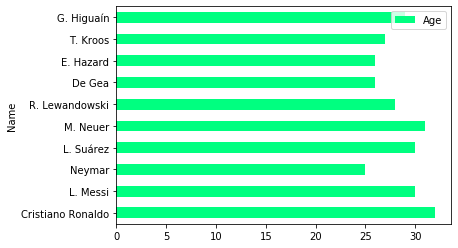

In [93]:
# Create a horizontal bar plot
df_pandas_small.plot(kind='barh', x='Name', y='Age', colormap='winter_r')
plt.show()

In [95]:
!ls data

5000_points.txt.gz	     ham.txt.gz      spam.txt.gz
Complete_Shakespeare.txt.gz  people.csv.gz
Fifa2018_dataset.csv.gz      ratings.csv.gz


In [96]:
file_path = "./data/Fifa2018_dataset.csv.gz"
# Load the Dataframe
fifa_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [97]:
# Check the schema of columns
fifa_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Wage: string (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Acceleration: string (nullable = true)
 |-- Aggression: string (nullable = true)
 |-- Agility: string (nullable = true)
 |-- Balance: string (nullable = true)
 |-- Ball control: string (nullable = true)
 |-- Composure: string (nullable = true)
 |-- Crossing: string (nullable = true)
 |-- Curve: string (nullable = true)
 |-- Dribbling: string (nullable = true)
 |-- Finishing: string (nullable = true)
 |-- Free kick accuracy: string (nullable = true)
 |-- GK diving: string (nullable = true)


In [98]:
# Show the first 10 observations
fifa_df.select("Name","Age","Nationality").show(10)

+-----------------+---+-----------+
|             Name|Age|Nationality|
+-----------------+---+-----------+
|Cristiano Ronaldo| 32|   Portugal|
|         L. Messi| 30|  Argentina|
|           Neymar| 25|     Brazil|
|        L. Suárez| 30|    Uruguay|
|         M. Neuer| 31|    Germany|
|   R. Lewandowski| 28|     Poland|
|           De Gea| 26|      Spain|
|        E. Hazard| 26|    Belgium|
|         T. Kroos| 27|    Germany|
|       G. Higuaín| 29|  Argentina|
+-----------------+---+-----------+
only showing top 10 rows



In [99]:
# Print the total number of rows
print("There are {} rows in the fifa_df DataFrame".format(fifa_df.count()))

# Create a temporary view of fifa_df
fifa_df.createOrReplaceTempView('fifa_df_table')

# Construct the "query" 
query = '''SELECT AGE FROM fifa_df_table WHERE Nationality == "Germany"'''

# Apply the SQL "query"
fifa_df_germany_age = spark.sql(query)

# Generate basic stastics
fifa_df_germany_age.describe().show()

# Convert fifa_df to fifa_df_germany_age_pandas DataFrame
fifa_df_germany_age_pandas = fifa_df_germany_age.toPandas()

There are 17981 rows in the fifa_df DataFrame
+-------+-----------------+
|summary|              AGE|
+-------+-----------------+
|  count|             1140|
|   mean|24.20263157894737|
| stddev|4.197096712293756|
|    min|               16|
|    max|               36|
+-------+-----------------+



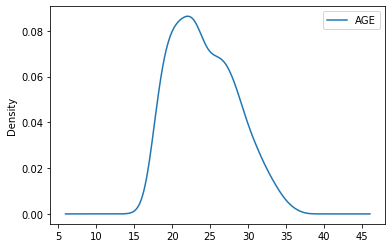

In [100]:

# Plot the 'Age' density of Germany Players
fifa_df_germany_age_pandas.plot(kind='density')
plt.show()

<img src=04.png/>

### PySpark MLlib

PySpark component for Machine Learning

supports RDD data structure

Various Tools:
* ML Algorithms: collaborative filtering, classification, clustering
* Featurization: feature extraction, transformation, dimensionality reduction, selection
* Pipeline: constructing, evaluating, tuning ML Pipelines

`Scikit-learn` python lib for data mining and machine learning, but only work for small dataset on a single machine.

`Spark MLlib` algorithms are designed for parallel processing on a cluster (supporting python, java, scala, R)

pySpark MLlib algorithms (3C's):
* __Classification__ (Binary/Multiclass) and __Regression__ : Identifying which categories a new observation belongs to
    * Linear SVM
    * logistic regression
    * decision trees
    * random forests
    * gradient-boosted trees
    * naive Bayes
    * linear least squares
    * Lasso, ridge regression
    * isotonic regression
    
* __Clustering__ : Grouping data based on similar characteristics
    * K-means
    * Gaussian mixture
    * Bisecting K-means
    * Streaming K-means
    
* __Collaborative filtering__ : Producing recommendations as in recommender engines
    * Alternating Least Squares (ALS)

#### MLlib imports

```
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

from pyspark.mllib.clustering import KMeans

from pyspark.mllib.recommendation import ALS
```

#### Collaborative filtering

commonly used for recommender systems to find users that share common interests.

* User-User Collaborative filtering : find users that are similar to target user
* Item-Item Collaborative filtering : find and recommend items that are similar to items with the target user

##### Rating

In [101]:
from pyspark.mllib.recommendation import Rating
r = Rating(user=1, product=2, rating=5.0)
r

Rating(user=1, product=2, rating=5.0)

##### randomSplit

In [102]:
data = sc.parallelize(range(1,11))
train, test = data.randomSplit([0.7,0.3])
train.collect(), test.collect()

([2, 5, 6, 7, 8, 9, 10], [1, 3, 4])

In [103]:
r1 = Rating(1,1,1.0)
r2 = Rating(1,2,2.0)
r3 = Rating(2,1,2.0)
ratings = sc.parallelize([r1,r2,r3])
ratings.collect()

[Rating(user=1, product=1, rating=1.0),
 Rating(user=1, product=2, rating=2.0),
 Rating(user=2, product=1, rating=2.0)]

In [104]:
# import ALS
from pyspark.mllib.recommendation import ALS

# train
model = ALS.train(ratings, rank=10, iterations=10)

In [105]:
# predict
unrated_RDD = sc.parallelize([(1,2), (1,1)])

predictions = model.predictAll(unrated_RDD)
predictions.collect()

[Rating(user=1, product=1, rating=1.0000307108700406),
 Rating(user=1, product=2, rating=1.9890342807951926)]

In [106]:
type(ratings)

pyspark.rdd.RDD

In [107]:
file_path = "./data/ratings.csv.gz"
# Load the data into RDD
data = sc.textFile(file_path)

# Split the RDD 
ratings = data.map(lambda l: l.split(','))

# Transform the ratings RDD 
ratings_final = ratings.map(lambda line: Rating(int(line[0]), int(line[1]), float(line[2])))

# Split the data into training and test
training_data, test_data = ratings_final.randomSplit([0.8, 0.2])

In [108]:
# Create the ALS model on the training data
model = ALS.train(training_data, rank=10, iterations=10)

# Drop the ratings column 
testdata_no_rating = test_data.map(lambda p: (p[0], p[1]))

# Predict the model  
predictions = model.predictAll(testdata_no_rating)

# Print the first rows of the RDD
predictions.take(2)

[Rating(user=548, product=1084, rating=2.997379667654668),
 Rating(user=580, product=1084, rating=3.6671932497383186)]

In [109]:
# Prepare ratings data
rates = ratings_final.map(lambda r: ((r[0], r[1]), r[2]))

# Prepare predictions data
preds = predictions.map(lambda r: ((r[0], r[1]), r[2]))

# Join the ratings data with predictions data
rates_and_preds = rates.join(preds)

# Calculate and print MSE
MSE = rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error of the model for the test data = {:.2f}".format(MSE))

Mean Squared Error of the model for the test data = 1.36


<img src=classification.png/>

```
denseVec = Vectors.dense([1,2,3])
sparseVec = Vectors.sparse(4, {1: 1.0, 2: 2.0})

A LabelledPoint is a wrapper for input features and predicted value

pos = LabeledPoint(1.0, [1.0, 0.0, 3.0])
neg = LabeledPoint(0.0, [2.0, 1.0, 1.0])
```


In [110]:
from pyspark.mllib.feature import HashingTF
sentence = "hello pyspark, you are great for big data"
words = sentence.split()
tf = HashingTF(10000)
tf.transform(words)

SparseVector(10000, {936: 1.0, 1666: 1.0, 4130: 1.0, 6577: 1.0, 7442: 1.0, 9068: 1.0, 9353: 1.0, 9788: 1.0})

In [111]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import HashingTF

In [112]:
data = [
    LabeledPoint(0.0, [0.0, 1.0]),
    LabeledPoint(1.0, [1.0, 0.0]),
]
RDD = sc.parallelize(data)
model = LogisticRegressionWithLBFGS.train(RDD)
t1 = model.predict([1.0, 0.0])
t2 = model.predict([0.0, 1.0])
t1, t2

(1, 0)

In [113]:
file_path_spam = "./data/spam.txt.gz"
file_path_non_spam = "./data/ham.txt.gz"

# Load the datasets into RDDs
spam_rdd = sc.textFile(file_path_spam)
non_spam_rdd = sc.textFile(file_path_non_spam)

# Split the email messages into words
spam_words = spam_rdd.map(lambda email: email.split(' '))
non_spam_words = non_spam_rdd.map(lambda email: email.split(' '))

# Print the first element in the split RDD
print("The first element in spam_words is", spam_words.first())
print("The first element in non_spam_words is", non_spam_words.first())

The first element in spam_words is ['You', 'have', '1', 'new', 'message.', 'Please', 'call', '08712400200.']
The first element in non_spam_words is ['Rofl.', 'Its', 'true', 'to', 'its', 'name']


In [114]:
# Create a HashingTf instance with 200 features
tf = HashingTF(numFeatures=200)

# Map each word to one feature
spam_features = tf.transform(spam_words)
non_spam_features = tf.transform(non_spam_words)

# Label the features: 1 for spam, 0 for non-spam
spam_samples = spam_features.map(lambda features:LabeledPoint(1, features))
non_spam_samples = non_spam_features.map(lambda features:LabeledPoint(0, features))

# Combine the two datasets
samples = spam_samples.union(non_spam_samples)

In [115]:
# Split the data into training and testing
train_samples, test_samples = samples.randomSplit([0.8, 0.2])

# Train the model
model = LogisticRegressionWithLBFGS.train(train_samples)

# Create a prediction label from the test data
predictions = model.predict(test_samples.map(lambda x: x.features))

# Combine original labels with the predicted labels
labels_and_preds = test_samples.map(lambda x: x.label).zip(predictions)

# Check the accuracy of the model on the test data
accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(test_samples.count())
print("Model accuracy : {:.2f}".format(accuracy))

Model accuracy : 0.87


Model accuracy : 0.84

<img src=clustering.png/>

In [116]:
file_path = "./data/5000_points.txt.gz"
# Load the dataset into a RDD
clusterRDD = sc.textFile(file_path)

# Split the RDD based on tab
rdd_split = clusterRDD.map(lambda x: x.split('\t'))

# Transform the split RDD by creating a list of integers
rdd_split_int = rdd_split.map(lambda x: [int(x[0]), int(x[1])])

# Count the number of rows in RDD 
print("There are {} rows in the rdd_split_int dataset".format(rdd_split_int.count()))

There are 5000 rows in the rdd_split_int dataset


[How to retrieve source code of Python functions](https://opensource.com/article/18/5/how-retrieve-source-code-python-functions)

```
import inspect
print(inspect.getsource(error))
```


In [117]:
from pyspark.mllib.clustering import KMeans

In [118]:
from math import sqrt
def error(point):
    center = model.centers[model.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

list_wssse = []
list_clst = list(range(13, 17))
for clst in list_clst:
    model = KMeans.train(rdd_split_int, clst, seed=1)
    WSSSE = rdd_split_int.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("The cluster {} has Within Set Sum of Squared Error {}".format(clst, WSSSE))
    list_wssse.append(WSSSE)

min_wssse = min(list_wssse)
min_clst = list_clst[list_wssse.index(min_wssse)]
print(min_clst, " : ", min_wssse)

# Train the model again with the best k 
model = KMeans.train(rdd_split_int, k=min_clst, seed=1)

# Get cluster centers
cluster_centers = model.clusterCenters
cluster_centers

The cluster 13 has Within Set Sum of Squared Error 255733506.37040392
The cluster 14 has Within Set Sum of Squared Error 250196589.84269145
The cluster 15 has Within Set Sum of Squared Error 213854847.90542698
The cluster 16 has Within Set Sum of Squared Error 168054840.6044716
16  :  168054840.6044716


[array([801616.78164557, 321123.34177215]),
 array([337565.11890244, 562157.17682927]),
 array([670929.06818182, 862765.73295455]),
 array([858947.9713467 , 546259.65902579]),
 array([606574.95622896, 574455.16835017]),
 array([244654.8856305 , 847642.04105572]),
 array([507818.31339031, 175610.41595442]),
 array([371264.28346457, 390845.72440945]),
 array([617926.67761194, 399415.94925373]),
 array([320602.55, 161521.85]),
 array([823421.2507837 , 731145.27272727]),
 array([417799.69426752, 787001.99363057]),
 array([852058.45259939, 157685.52293578]),
 array([167529.        , 347702.66966967]),
 array([139682.37572254, 558123.40462428]),
 array([413909.40888889, 412779.54666667])]

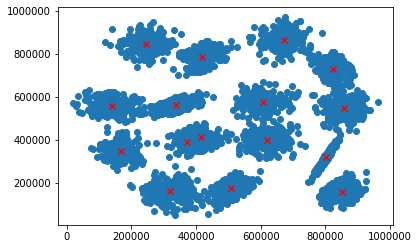

In [119]:
import matplotlib.pyplot as plt
import pandas as pd
# Convert rdd_split_int RDD into Spark DataFrame
rdd_split_int_df = spark.createDataFrame(rdd_split_int, schema=["col1", "col2"])

# Convert Spark DataFrame into Pandas DataFrame
rdd_split_int_df_pandas = rdd_split_int_df.toPandas()

# Convert cluster_centers into Panda DataFrame
cluster_centers_pandas = pd.DataFrame(cluster_centers, columns=["col1", "col2"])

# Create an overlaid scatter plot
plt.scatter(rdd_split_int_df_pandas["col1"], rdd_split_int_df_pandas["col2"])
plt.scatter(cluster_centers_pandas["col1"], cluster_centers_pandas["col2"], color="red", marker="x")
plt.show()